**Load Environment Variables**

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")
DB_HOST = "127.0.0.1"
DB_PORT = 3306
DB_NAME = os.getenv("DB_NAME")


**Create SQLAlchemy Engine**

In [2]:
from sqlalchemy import create_engine

# Create a MySQL connection engine
engine = create_engine(f"mysql+mysqlconnector://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")


###  **Query 1: Overlapping Schedules** 

**Purpose:** Identify media scheduled to air overlapping on the same platform.  
**Business Use Case:** Helps prevent double-booking and ensures proper broadcast planning.


In [3]:
query1 = """
SELECT
    m1.title AS media_title,
    p1.name AS platform_name,
    s1.air_datetime AS schedule1_start,
    s2.air_datetime AS schedule2_start,
    s1.duration_minutes AS duration_minutes
FROM
    schedule s1
JOIN
    schedule s2 ON s1.media_id = s2.media_id
    AND s1.platform_id = s2.platform_id  -- THIS IS THE NEW CONDITION
    AND s1.schedule_id < s2.schedule_id
JOIN
    media m1 ON s1.media_id = m1.media_id
JOIN
    platform p1 ON s1.platform_id = p1.platform_id
WHERE
    s1.air_datetime < s2.air_datetime + INTERVAL s2.duration_minutes MINUTE
    AND s2.air_datetime < s1.air_datetime + INTERVAL s1.duration_minutes MINUTE;
"""
df1 = pd.read_sql(query1, engine)
df1


,media_title,platform_name,schedule1_start,schedule2_start,duration_minutes
0,Inception,Netflix,2025-08-15 20:00:00,2025-08-15 21:00:00,120


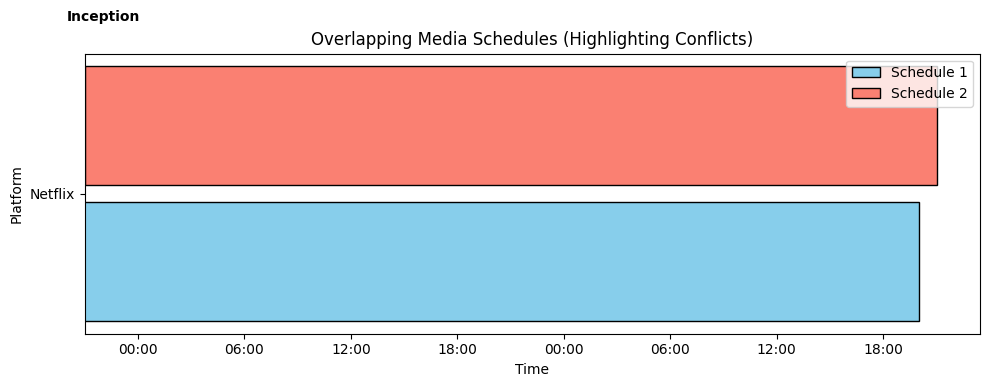

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

plt.figure(figsize=(10, 4))

# Small vertical offset for schedule bars
bar_offset = 0.2

for i, row in df1.iterrows():
    # Convert to datetime if needed
    s1_start = pd.to_datetime(row['schedule1_start'])
    s2_start = pd.to_datetime(row['schedule2_start'])
    duration = pd.Timedelta(minutes=row['duration_minutes'])
    
    # Plot Schedule 1
    plt.barh(
        y=i - bar_offset,
        width=duration.total_seconds()/3600,
        left=s1_start,
        height=0.35,
        color="skyblue",
        edgecolor="black",
        label="Schedule 1" if i==0 else ""
    )
    
    # Plot Schedule 2
    plt.barh(
        y=i + bar_offset,
        width=duration.total_seconds()/3600,
        left=s2_start,
        height=0.35,
        color="salmon",
        edgecolor="black",
        label="Schedule 2" if i==0 else ""
    )
    
    
    # Annotate media title **above the bars**
    plt.text(
        s1_start, i + 0.5,  # above the top bar
        row['media_title'], 
        va='bottom', ha='left', fontsize=10, fontweight='bold'
    )

# Y-axis = platform names
plt.yticks(range(len(df1)), df1['platform_name'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel("Time")
plt.ylabel("Platform")
plt.title("Overlapping Media Schedules (Highlighting Conflicts)")
plt.legend()
plt.tight_layout()
plt.show()


**Interpretation**: <br>
Rows indicate media scheduled at overlapping times on the same platform. These conflicts should be resolved to maintain smooth broadcasting.

### **Query 2: Licenses Expiring Soon**

**Purpose:** Find content licenses expiring within the next 30 days.<br>
**Business Use Case:** Alerts the business to renew or renegotiate licenses to avoid service interruptions.

In [5]:
query2 = """
SELECT 
    c.title,
    p.name AS platform,
    l.end_date
FROM license l
JOIN content c ON l.content_id = c.content_id
JOIN platform p ON l.platform_id = p.platform_id
WHERE l.end_date BETWEEN CURDATE() AND DATE_ADD(CURDATE(), INTERVAL 30 DAY);
"""
df2 = pd.read_sql(query2, engine)
df2


,title,platform,end_date
0,Gladiator,HBO Max,2025-09-06
1,The Matrix,Prime Video,2025-08-31


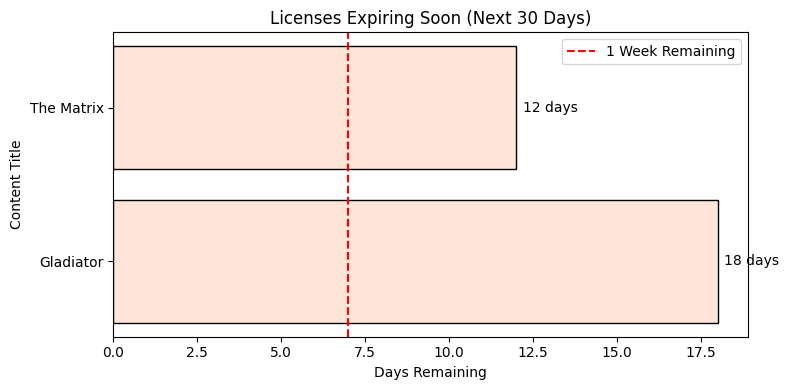

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample df2 (for reference)
# df2 = pd.DataFrame({
#     'title': ['Gladiator', 'The Matrix'],
#     'platform': ['HBO Max', 'Prime Video'],
#     'end_date': ['2025-09-06', '2025-08-31']
# })

# Convert end_date to datetime
df2['end_date'] = pd.to_datetime(df2['end_date'])
df2['days_remaining'] = (df2['end_date'] - pd.to_datetime("today")).dt.days

plt.figure(figsize=(8, 4))

# Color by urgency (less days = darker red)
colors = [sns.color_palette("Reds", 9)[max(0, 9 - int(d))] for d in df2['days_remaining']]

# Horizontal bars
plt.barh(df2['title'], df2['days_remaining'], color=colors, edgecolor='black')

# Annotate days remaining
for i, days in enumerate(df2['days_remaining']):
    plt.text(days + 0.2, i, f"{days} days", va='center', fontsize=10)

# Optional: vertical line for urgent threshold (7 days)
plt.axvline(x=7, color='red', linestyle='--', label="1 Week Remaining")
plt.xlabel("Days Remaining")
plt.ylabel("Content Title")
plt.title("Licenses Expiring Soon (Next 30 Days)")
plt.legend()
plt.tight_layout()
plt.show()



In [7]:
df2.columns

Index(['title', 'platform', 'end_date', 'days_remaining'], dtype='object')

**Interpretation**:<br>
Returned rows show licenses at risk of expiration soon. Immediate action may be required to maintain content availability.

### **Query 3: Schedules Without Valid Licenses**

**Purpose:** Detect scheduled media airing without a valid license.<br>
**Business Use Case:** Ensures compliance with licensing agreements, preventing legal or contractual issues.

In [8]:
query3 = """
SELECT 
    m.title,
    p.name AS platform,
    s.air_datetime
FROM schedule s
JOIN media m ON s.media_id = m.media_id
JOIN platform p ON s.platform_id = p.platform_id
LEFT JOIN license l
    ON m.media_id = l.content_id
    AND s.platform_id = l.platform_id
    AND s.air_datetime BETWEEN l.start_date AND l.end_date
WHERE l.license_id IS NULL;
"""
df3 = pd.read_sql(query3, engine)
df3


,title,platform,air_datetime
0,Inception,Netflix,2025-08-17 20:00:00
1,Toy Story,Disney+,2025-08-18 18:00:00
2,Parasite,Disney+,2025-08-21 20:00:00


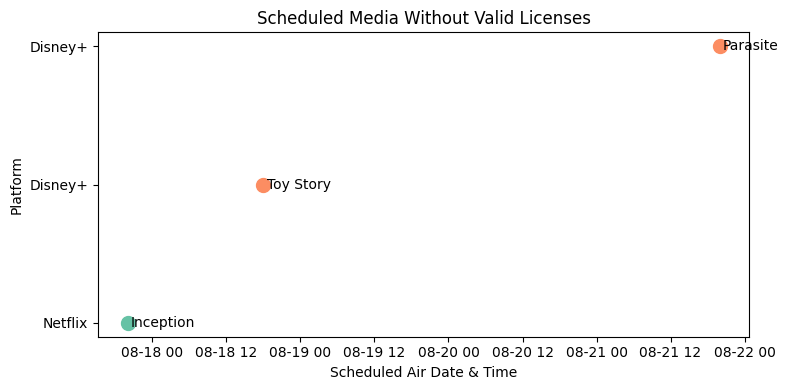

In [9]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Convert air_datetime to datetime
df3['air_datetime'] = pd.to_datetime(df3['air_datetime'])

plt.figure(figsize=(8, 4))

# Map each platform to a color
platforms = df3['platform'].unique()
palette = sns.color_palette("Set2", len(platforms))
platform_colors = dict(zip(platforms, palette))

# Plot each airing as a point
for i, row in df3.iterrows():
    plt.plot(
        row['air_datetime'], i,
        marker='o', markersize=10,
        color=platform_colors[row['platform']]
    )
    # Annotate media title next to the point
    plt.text(
        row['air_datetime'] + pd.Timedelta(hours=0.5), i,
        row['title'], va='center', fontsize=10
    )

plt.yticks(range(len(df3)), df3['platform'])
plt.xlabel("Scheduled Air Date & Time")
plt.ylabel("Platform")
plt.title("Scheduled Media Without Valid Licenses")
plt.tight_layout()
plt.show()



**Interpretation**:<br>
Any returned rows indicate media scheduled without an active license, highlighting urgent compliance issues.

### **Query 4: License Conflicts (Exclusive but Appears Elsewhere)**

**Purpose:** Identify content marked as exclusive but scheduled or licensed on other platforms.<br>
**Business Use Case:** Helps maintain contractual exclusivity and prevents violations that could lead to penalties.

In [10]:
query4 = """
SELECT DISTINCT 
    c.title,
    p.name AS exclusive_platform,
    l.exclusive
FROM license l
JOIN content c ON l.content_id = c.content_id
JOIN platform p ON l.platform_id = p.platform_id
WHERE l.exclusive = 1
  AND EXISTS (
      SELECT 1
      FROM schedule s
      JOIN platform p2 ON s.platform_id = p2.platform_id
      WHERE s.media_id = (
          SELECT media_id FROM media WHERE title = c.title LIMIT 1
      )
        AND p2.platform_id <> l.platform_id
  );
"""
df4 = pd.read_sql(query4, engine)
df4


,title,exclusive_platform,exclusive
0,Parasite,Netflix,1


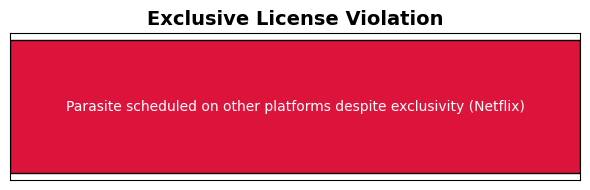

In [11]:
import matplotlib.pyplot as plt

# Example single row
row = df4.iloc[0]

plt.figure(figsize=(6, 2))

# Draw a horizontal bar to highlight violation
plt.barh([0], [1], color='crimson', edgecolor='black', height=0.6)
plt.text(0.5, 0, f"{row['title']} scheduled on other platforms despite exclusivity ({row['exclusive_platform']})",
         ha='center', va='center', color='white', fontsize=10)

plt.xlim(0, 1)
plt.yticks([])
plt.xticks([])
plt.title("Exclusive License Violation", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


**Interpretation**:<br>
Rows indicate exclusivity violations. Addressing these protects revenue and maintains platform agreements.

### **Query 5: Multi-Region Broadcast Pattern**

**Purpose:** Detect media airing in multiple regions within a short timeframe (≤7 days). <br>
**Business Use Case:** Monitors simultaneous or near-simultaneous releases for global content, important for marketing and audience engagement.

In [12]:
query5 = """
SELECT 
    m.title,
    MIN(DATE(s.air_datetime)) AS first_air_date,
    MAX(DATE(s.air_datetime)) AS last_air_date,
    COUNT(DISTINCT p.region) AS region_count,
    GROUP_CONCAT(DISTINCT p.region ORDER BY p.region SEPARATOR ', ') AS regions
FROM schedule s
JOIN media m ON s.media_id = m.media_id
JOIN platform p ON s.platform_id = p.platform_id
GROUP BY m.title
HAVING COUNT(DISTINCT p.region) > 1
   AND DATEDIFF(MAX(DATE(s.air_datetime)), MIN(DATE(s.air_datetime))) <= 7
ORDER BY m.title, first_air_date;

"""
df5 = pd.read_sql(query5, engine)
df5


,title,first_air_date,last_air_date,region_count,regions
0,Avatar 3,2025-08-05,2025-08-07,3,"EU, LATAM, US"
1,Inception,2025-08-15,2025-08-17,2,"EU, US"
2,Quantum Rift,2025-09-01,2025-09-02,3,"FR, UK, US"


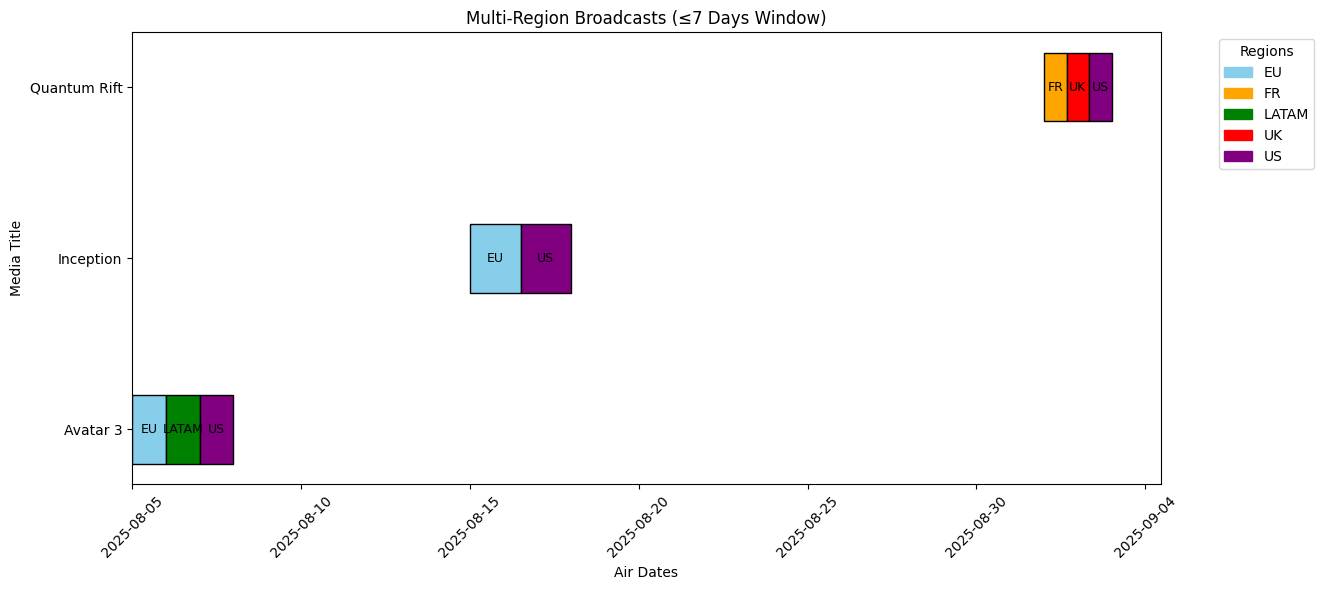

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Example dataframe for demonstration
# df5 should already have first_air_date, last_air_date, and regions column (comma-separated)
# e.g., 'EU, LATAM, US'
df5['first_air_date'] = pd.to_datetime(df5['first_air_date'])
df5['last_air_date'] = pd.to_datetime(df5['last_air_date'])

# Assign colors to regions
all_regions = set(r.strip() for regions in df5['regions'] for r in regions.split(','))
region_colors = dict(zip(sorted(all_regions), ['skyblue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']))

fig, ax = plt.subplots(figsize=(12, 6))

for i, row in df5.iterrows():
    regions = [r.strip() for r in row['regions'].split(',')]
    total_days = (row['last_air_date'] - row['first_air_date']).days + 1
    
    # If there are multiple regions, split the bar equally
    segment_width = total_days / len(regions)
    
    for j, region in enumerate(regions):
        start_date = row['first_air_date'] + pd.Timedelta(days=j * segment_width)
        ax.barh(
            row['title'],
            width=segment_width,
            left=start_date,
            height=0.4,
            color=region_colors[region],
            edgecolor='black'
        )
        # Optional: annotate each segment with the region
        ax.text(
            start_date + pd.Timedelta(days=segment_width/2),
            i,
            region,
            ha='center',
            va='center',
            color='black',
            fontsize=9
        )

# Formatting x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.xlabel("Air Dates")
plt.ylabel("Media Title")
plt.title("Multi-Region Broadcasts (≤7 Days Window)")
plt.tight_layout()

# Optional legend
handles = [plt.Rectangle((0,0),1,1,color=color) for color in region_colors.values()]
ax.legend(handles, region_colors.keys(), title="Regions", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


**Interpretation**: <br>
Returned rows highlight media released across multiple regions almost simultaneously. This helps plan global marketing campaigns and manage licensing considerations.

#  Conclusion & Next Steps

###  Summary of Findings
Through SQL queries and visualizations, we explored critical aspects of media scheduling and licensing:
- **Overlapping Schedules** → highlighted potential broadcast conflicts that need resolution.  
- **Licenses Expiring Soon** → flagged contracts at risk of lapsing, requiring timely renewal.  
- **Schedules Without Valid Licenses** → exposed compliance issues that could create legal risks.  
- **Exclusive License Conflicts** → detected exclusivity violations, protecting contractual obligations.  
- **Multi-Region Broadcast Patterns** → identified globally coordinated releases, supporting international marketing strategies.  

###  Key Insights
- Overlaps and invalid schedules can directly disrupt broadcast planning.  
- Proactive license monitoring ensures continuous content availability.  
- Enforcing exclusivity safeguards both revenue and platform trust.  
- Global release patterns provide opportunities for synchronized campaigns.  

###  Limitations
- Data used was partially synthetic and may not represent real-world scale.  
- Audience/viewership impact was not included, which could change prioritization of conflicts.  
- Regional analysis was high-level; more granular subregions could provide deeper insights.  

###  Next Steps
- **Automation:** Integrate queries into a pipeline with alerts (e.g., daily overlap/expiration checks).  
- **Scalability:** Expand dataset to real-world volumes for stress testing.  
- **Business Impact:** Link scheduling conflicts with audience data to quantify revenue implications.  
- **Visualization:** Build dashboards (e.g., in Tableau or Plotly Dash) for continuous monitoring.  

---

 **Final Note:**  
This project demonstrates how SQL-driven analytics can ensure operational efficiency, licensing compliance, and strategic decision-making in media distribution. By combining queries, visualizations, and interpretations, we provide a foundation that can scale into production-ready monitoring systems for real-world use.  
